<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [195]:
!export PATH=/Library/TeX/texbin:$PATH

In [159]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [160]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

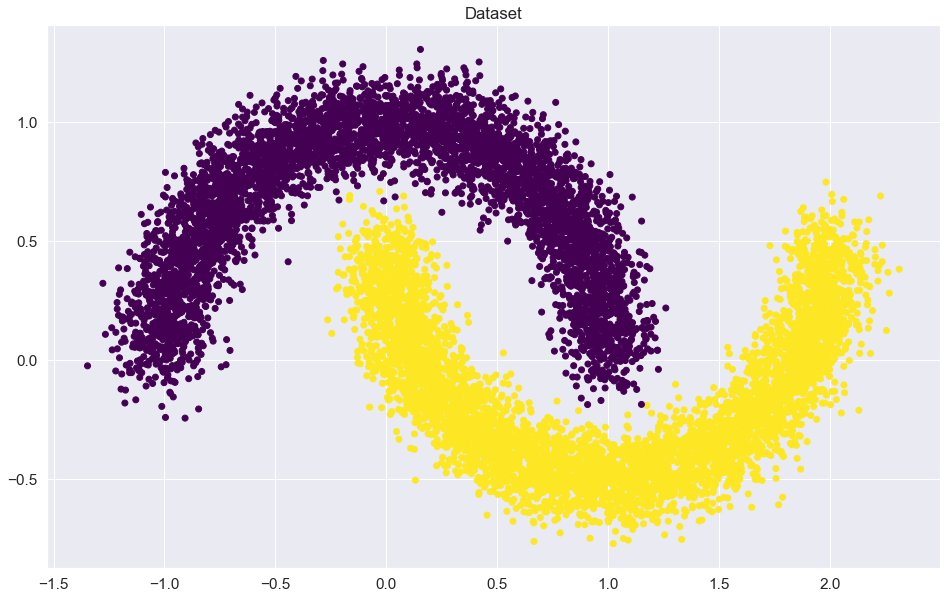

In [161]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [162]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [163]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [164]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [165]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [166]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [167]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[1.6314],
         [0.9110]], requires_grad=True),
 Parameter containing:
 tensor([0.0255], requires_grad=True)]

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [168]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch.view(outp.shape[0], 1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = 1 / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6328125
Iteration: 100
Batch accuracy: 0.6796875
Iteration: 200
Batch accuracy: 0.75
Iteration: 300
Batch accuracy: 0.8125
Iteration: 400
Batch accuracy: 0.78125
Iteration: 500
Batch accuracy: 0.8671875
Iteration: 600
Batch accuracy: 0.8359375
Iteration: 700
Batch accuracy: 0.796875
Iteration: 800
Batch accuracy: 0.8125

Iteration: 877.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**  потребовалось 873 итерации

### Визуализируем результаты

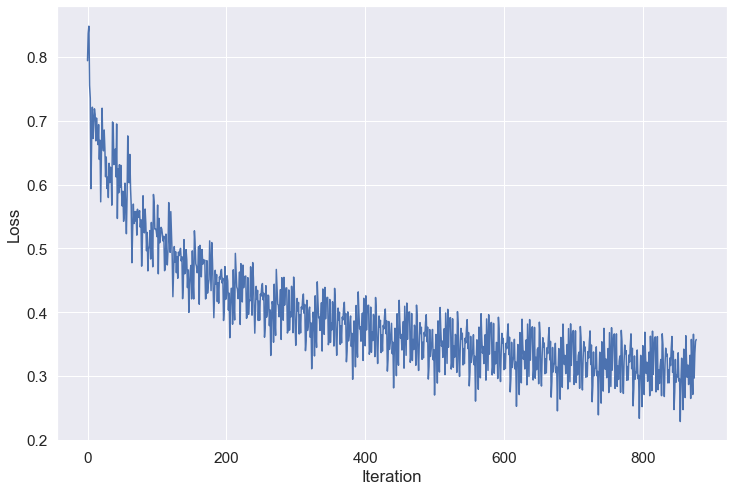

In [169]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

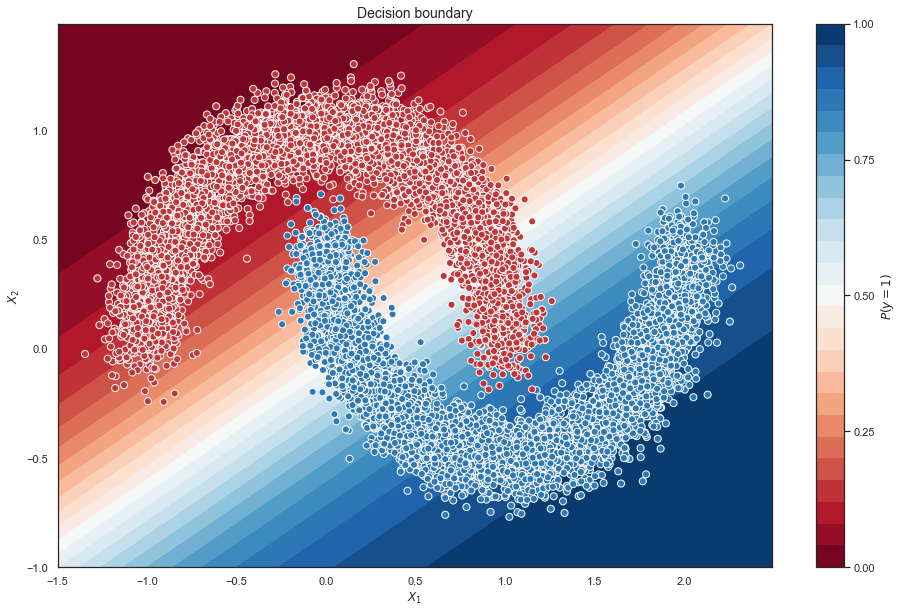

In [170]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [171]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = 1 / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [172]:
from sklearn.metrics import accuracy_score
y_pred = predict(val_dataloader, linear_regression)
accuracy_score(y_val, y_pred)

0.8552

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [173]:
import os
import torchvision.transforms as tfs
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, num_workers=8)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=8)

In [174]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [175]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [176]:
activation = nn.ELU()

In [177]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

In [178]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [179]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [180]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))

            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))

            preds = outp.argmax(-1)
            correct = preds[preds == y_batch]
            all_ = y_batch.shape[0]
            epoch_correct += correct.count_nonzero()
            epoch_all += all_

            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7845051884651184
Loader: valid. Accuracy: 0.8295272588729858
Epoch: 2
Loader: train. Accuracy: 0.8439503312110901
Loader: valid. Accuracy: 0.8561698794364929
Epoch: 3
Loader: train. Accuracy: 0.8614115715026855
Loader: valid. Accuracy: 0.8643830418586731
Epoch: 4
Loader: train. Accuracy: 0.870759904384613
Loader: valid. Accuracy: 0.8687900900840759
Epoch: 5
Loader: train. Accuracy: 0.8768028616905212
Loader: valid. Accuracy: 0.8678886294364929
Epoch: 6
Loader: train. Accuracy: 0.8814937472343445
Loader: valid. Accuracy: 0.866286039352417
Epoch: 7
Loader: train. Accuracy: 0.8842481374740601
Loader: valid. Accuracy: 0.8665865659713745
Epoch: 8
Loader: train. Accuracy: 0.886384904384613
Loader: valid. Accuracy: 0.8681890964508057
Epoch: 9
Loader: train. Accuracy: 0.8872863054275513
Loader: valid. Accuracy: 0.8622796535491943
Epoch: 10
Loader: train. Accuracy: 0.8886218070983887
Loader: valid. Accuracy: 0.8693910241127014


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [181]:
def test_activation_function(activation):
    model = nn.Sequential(nn.Flatten(),
                          nn.Linear(784, 128),
                          activation(),
                          nn.Linear(128, 128),
                          activation(),
                          nn.Linear(128, 10))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device))
                preds = outp.argmax(-1)
                correct = preds[preds == y_batch]
                all_ = y_batch.shape[0]
                epoch_correct += correct.count_nonzero()
                epoch_all += all_
                if k == "train":
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]


In [182]:
plain_accuracy = test_activation_function(Identical)
elu_accuracy = test_activation_function(nn.ELU)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.7692307829856873
Loader: valid. Accuracy: 0.7912660241127014
Epoch: 2
Loader: train. Accuracy: 0.8010149598121643
Loader: valid. Accuracy: 0.8017828464508057
Epoch: 3
Loader: train. Accuracy: 0.8058059811592102
Loader: valid. Accuracy: 0.8030849099159241
Epoch: 4
Loader: train. Accuracy: 0.8080929517745972
Loader: valid. Accuracy: 0.8051882982254028
Epoch: 5
Loader: train. Accuracy: 0.8091112375259399
Loader: valid. Accuracy: 0.8066906929016113
Epoch: 6
Loader: train. Accuracy: 0.8106136322021484
Loader: valid. Accuracy: 0.8069911599159241
Epoch: 7
Loader: train. Accuracy: 0.8117988705635071
Loader: valid. Accuracy: 0.8069911599159241
Epoch: 8
Loader: train. Accuracy: 0.8130508661270142
Loader: valid. Accuracy: 0.8073918223381042
Epoch: 9
Loader: train. Accuracy: 0.8138521909713745
Loader: valid. Accuracy: 0.8078926205635071
Epoch: 10
Loader: train. Accuracy: 0.8147202134132385
Loader: valid. Accuracy: 0.8087940812110901
Epoch: 1
Loader: train. Accur

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

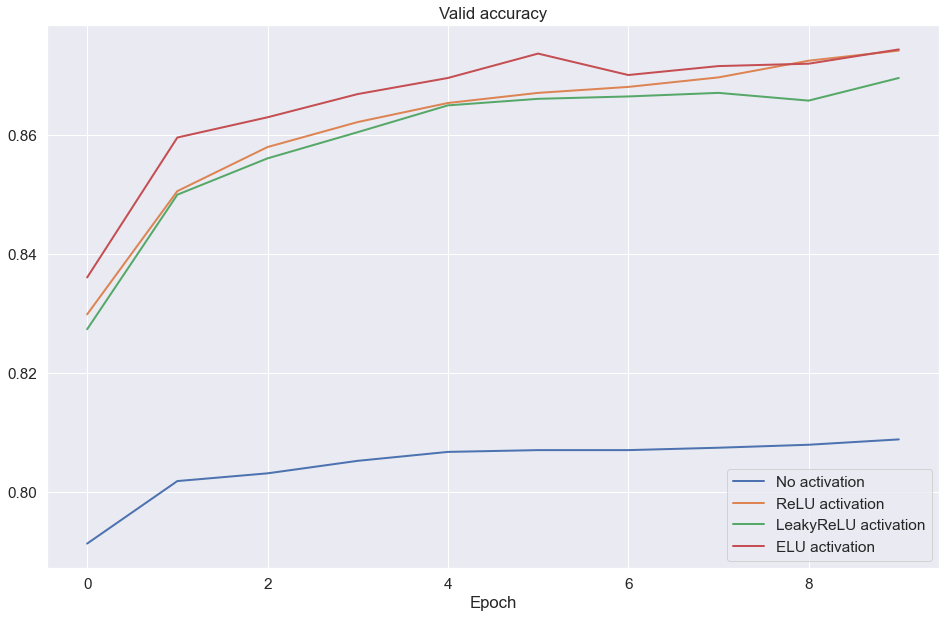

In [183]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

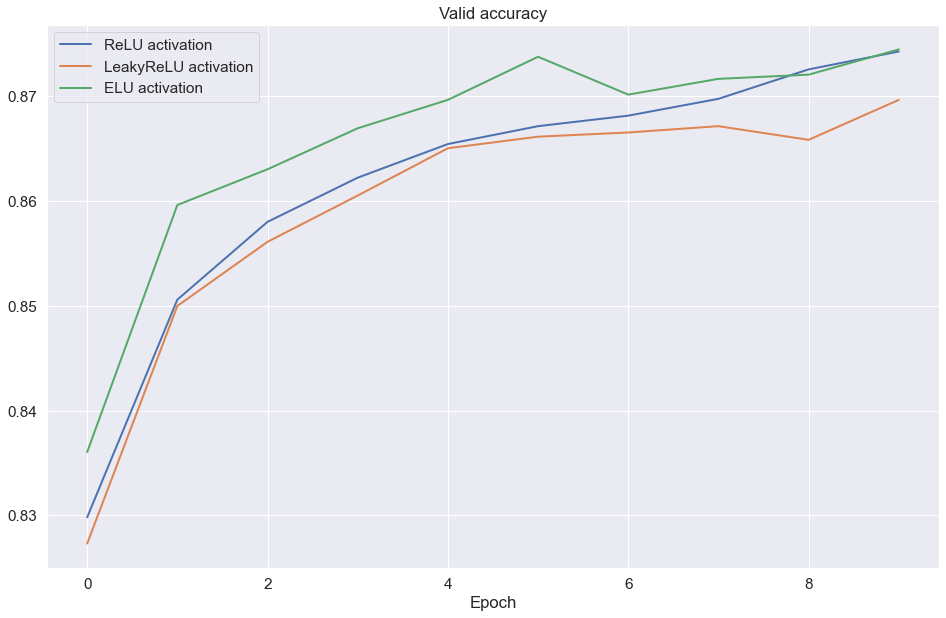

In [184]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** активация ELU показала наивысшую `accuracy`, в то же время ReLU не сильно отстала

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

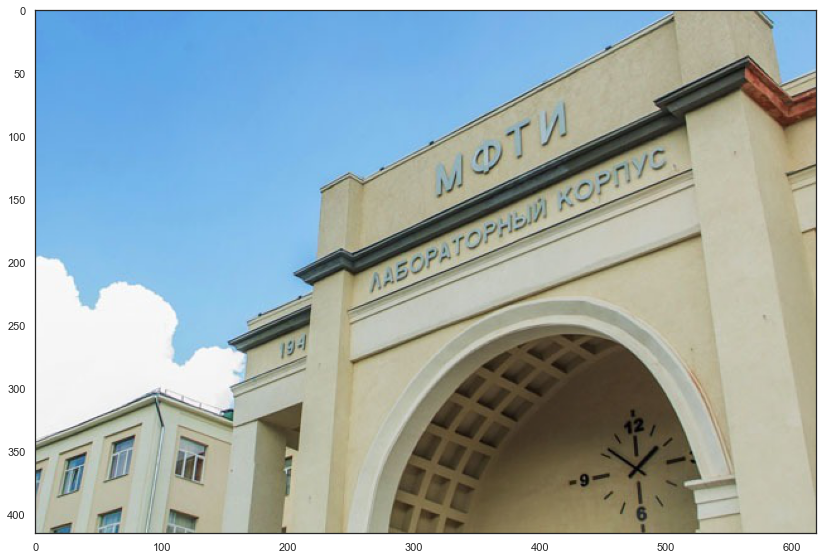

In [185]:
import cv2
sns.set(style="white")
img = cv2.imread("sample.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 10))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [186]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[1, 1, 0],
[0, -2, 0],
[0, 1, 1]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


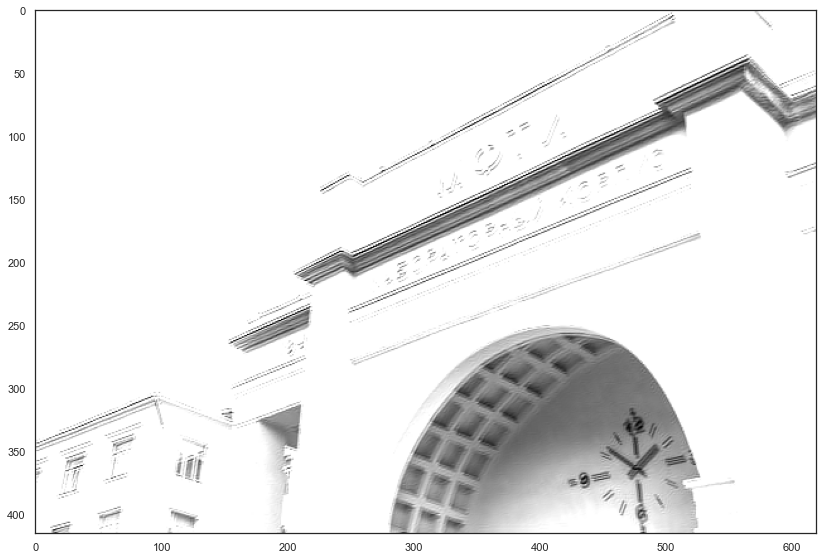

In [187]:
plt.figure(figsize=(14, 10))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

**Ответ:**

1) Размытие - E

2) Увеличение резкости - Д

3) Тождественное преобразование - А

4) Выделение вертикальных границ - В

5) Выделение горизонтальных границ - Б 

6) Выделение границ - Г



### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




Расчет \
The formula for the output height is \
h1 = 1+  (h0 - f +2p)/2, \
where: \
h0 = old height \
h1 = new height \
f  = size of filter \
p  = size of padding \

1. First Convolution Layer:      self.conv1 =  nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5): 
Input = 28 x 28 x 1 (black and white image of size 28 x 28) i.e. \
h0 = 28 \
Filter size (f) = 3 \
New height h1 = 1+(28-3) = 26 \
Output channel = 6 \
Output = 26 x 26 x 6 \
2. First pooling:      self.pool  =  nn.MaxPool2d(kernel_size=2, stride=2) 
Input = 26 x 26 x 6 i.e. \
h0 = 26 \
Stride = 2 \
New height h1 = 26/2 = 13 \
Output = 13 x 13 x 6 \
3. Second Convolution Layer:     self.conv2  =  nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) :
Input = 13 x 13 x 6  i.e. \
h0 = 13 \
Filter size (f) = 3 \
New height h1 = 1+(12-3) = 10 \
Output channel = 16 \
Output = 10 x 10 x 16 \
4. First pooling:      self.pool  =  nn.MaxPool2d(kernel_size=2, stride=2) 
Input = 10 x 10 x 16 i.e. \
h0 = 10 \
Stride = 2 \
New height h1 = 10/2 = 5 \
Output = 5 x 5 x 16 \
And this is how we get (5 x 5 x 16) in self.fc1 =  nn.Linear(5 x 5 x 16, 120).

In [188]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(5 * 5 * 16, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.fl(x) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [189]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [190]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)

            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    
            preds = outp.argmax(-1)
            correct = preds[preds == y_batch]
            all_ = y_batch.shape[0]
            epoch_correct += correct.count_nonzero()
            epoch_all += all_
            
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.788161039352417
Loader: valid. Accuracy: 0.8691906929016113
Epoch: 2
Loader: train. Accuracy: 0.8717114329338074
Loader: valid. Accuracy: 0.875901460647583
Epoch: 3
Loader: train. Accuracy: 0.8809261322021484
Loader: valid. Accuracy: 0.8821113705635071
Epoch: 4
Loader: train. Accuracy: 0.885299801826477
Loader: valid. Accuracy: 0.8853164911270142
Epoch: 5
Loader: train. Accuracy: 0.8880876302719116
Loader: valid. Accuracy: 0.8862179517745972
Epoch: 6
Loader: train. Accuracy: 0.8901909589767456
Loader: valid. Accuracy: 0.8868188858032227
Epoch: 7
Loader: train. Accuracy: 0.89186030626297
Loader: valid. Accuracy: 0.8849158883094788
Epoch: 8
Loader: train. Accuracy: 0.8931958079338074
Loader: valid. Accuracy: 0.8871194124221802
Epoch: 9
Loader: train. Accuracy: 0.8945479393005371
Loader: valid. Accuracy: 0.8877203464508057
Epoch: 10
Loader: train. Accuracy: 0.8953492045402527
Loader: valid. Accuracy: 0.8872195482254028


In [191]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

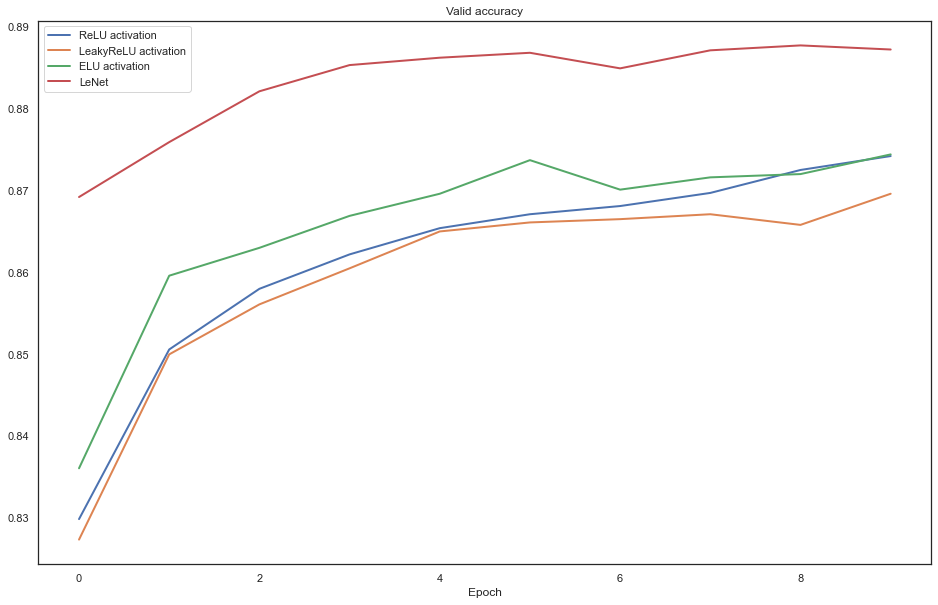

In [192]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** примерно 0.89